# ECCOv4r3 heat budget test

In [1]:
import numpy as np
import xarray as xr
import pandas as pd

from xmitgcm import open_mdsdataset
import xgcm

import matplotlib.pyplot as plt
%matplotlib inline

## Define plotting funtion

In [2]:
def quick_llc_plot(data, axis_off=False, **kwargs):
    face_to_axis = {0: (2, 0), 1: (1, 0), 2: (0, 0),
                    3: (2, 1), 4: (1, 1), 5: (0, 1),
                    7: (0, 2), 8: (1, 2), 9: (2, 2),
                    10: (0, 3), 11: (1, 3), 12: (2, 3)}
    transpose = [7, 8, 9, 10, 11, 12]
    gridspec_kw = dict(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    fig, axes = plt.subplots(nrows=3, ncols=4, gridspec_kw=gridspec_kw, figsize=(10,4))
    for face, (j, i) in face_to_axis.items():
        data_ax = data.sel(face=face)
        ax = axes[j,i]
        yincrease = True
        if face in transpose:
            data_ax = data_ax.transpose()
            yincrease = False
        p = data_ax.plot(ax=ax, yincrease=yincrease, **kwargs)
        if axis_off:
            ax.axis('off')
        ax.set_title('')
    # use implicit way
    cbar = fig.colorbar(p, ax=axes.ravel().tolist(), shrink=0.95)

## Load datasets

In [3]:
ds_ave = open_mdsdataset('/rigel/ocp/users/jt2796/MITgcm/mysetups/ECCO_v4_r3/run/',
                         delta_t=3600, ref_date='1991-12-15 12:0:0', geometry='llc',
                         prefix=['monave2d','monave3d'])

/rigel/home/jt2796/miniconda/envs/default/lib/python2.7/site-packages/xmitgcm-0.2.1-py2.7.egg/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


In [4]:
ds_ave['time'] = pd.date_range(start='1992-01-15', periods=2*24*12, freq='SMS')[::2]

In [5]:
ds_snp = open_mdsdataset('/rigel/ocp/users/jt2796/MITgcm/mysetups/ECCO_v4_r3/run/',
                         delta_t=3600, ref_date='1992-1-1 12:0:0', geometry='llc',
                         prefix=['monsnp2d','monsnp3d'])

### Geothermal flux

In [6]:
geoflx = np.fromfile('/rigel/ocp/users/jt2796/ECCO_v4_r2/geothermalFlux.bin', dtype=np.float32)
geoflx = geoflx.byteswap().reshape([105300,1])

In [7]:
# Reshape data for each face and save as xarray data array in LLC format
geoflx00 = xr.DataArray(geoflx[:8100,0].reshape([90,90]),coords=[np.arange(0,90,1),np.arange(0,90,1)],
                        dims=['j','i'])
geoflx01 = xr.DataArray(geoflx[8100:16200,0].reshape([90,90]),coords=[np.arange(0,90,1),np.arange(0,90,1)],
                        dims=['j','i'])
geoflx02 = xr.DataArray(geoflx[16200:24300,0].reshape([90,90]),coords=[np.arange(0,90,1),np.arange(0,90,1)],
                        dims=['j','i'])
geoflx03 = xr.DataArray(geoflx[24300:32400,0].reshape([90,90]),coords=[np.arange(0,90,1),np.arange(0,90,1)],
                        dims=['j','i'])
geoflx04 = xr.DataArray(geoflx[32400:40500,0].reshape([90,90]),coords=[np.arange(0,90,1),np.arange(0,90,1)],
                        dims=['j','i'])
geoflx05 = xr.DataArray(geoflx[40500:48600,0].reshape([90,90]),coords=[np.arange(0,90,1),np.arange(0,90,1)],
                        dims=['j','i'])
geoflx06 = xr.DataArray(geoflx[48600:56700,0].reshape([90,90]),coords=[np.arange(0,90,1),np.arange(0,90,1)],
                        dims=['j','i'])

geoflx0709 = geoflx[56700:81000,0].reshape([90,270])
geoflx07 = xr.DataArray(geoflx0709[:,:90],coords=[np.arange(0,90,1),np.arange(0,90,1)],dims=['j','i'])
geoflx08 = xr.DataArray(geoflx0709[:,90:180],coords=[np.arange(0,90,1),np.arange(0,90,1)],dims=['j','i'])
geoflx09 = xr.DataArray(geoflx0709[:,180:],coords=[np.arange(0,90,1),np.arange(0,90,1)],dims=['j','i'])

geoflx1012 = geoflx[81000:,0].reshape([90,270])
geoflx10 = xr.DataArray(geoflx1012[:,:90],coords=[np.arange(0,90,1),np.arange(0,90,1)],dims=['j','i'])
geoflx11 = xr.DataArray(geoflx1012[:,90:180],coords=[np.arange(0,90,1),np.arange(0,90,1)],dims=['j','i'])
geoflx12 = xr.DataArray(geoflx1012[:,180:],coords=[np.arange(0,90,1),np.arange(0,90,1)],dims=['j','i'])

In [8]:
geoflx_llc = xr.concat([geoflx00,geoflx01,geoflx02,geoflx03,geoflx04,geoflx05,geoflx06,
                        geoflx07,geoflx08,geoflx09,geoflx10,geoflx11,geoflx12], 'face')

## Subset two years

In [9]:
tstart = '1994-01-15'
tend = '1995-12-15'

In [10]:
ds_ave = ds_ave.sel(time=slice(tstart,tend))
ds_snp = ds_snp.sel(time=slice(tstart,tend))

## Number of seconds between each snapshot
**Note**: There are no snapshots for the first and last time point. Thus, we are skipping budget calculations for January and December 1992.

In [11]:
dt = ds_snp.time[1:].load()
# delta t in seconds. Note: devide by 10**9 to convert nanoseconds to seconds
dt.values = [float(t)/10**9 for t in np.diff(ds_snp.time)]

# time axis of dt should be the same as of the monthly averages
dt.time.values = ds_ave.time[1:-1].values

## Relevant constants

In [12]:
# Density kg/m^3
rhoconst = 1029

# Heat capacity (J/kg/K)
c_p = 3994

# Constants for surface heat penetration (from Table 2 of Paulson and Simpson, 1977)
R = 0.62
zeta1 = 0.6
zeta2 = 20.0

## Ocean depth

In [13]:
# Ocean depth (m)
Depth = ds_snp.Depth.load()

## Grid dimensions

In [14]:
dxG = ds_ave.dxG.load()
dyG = ds_ave.dyG.load()
drF = ds_ave.drF.load()

In [15]:
rA = ds_ave.rA.load()
hFacC = ds_ave.hFacC.load()

In [16]:
# Volume (m^3)
vol = (rA*drF*hFacC).transpose('face','k','j','i')

## Land mask 

In [17]:
# Make copy of hFacC
mskC = hFacC.copy(deep=True).load()

# Change all fractions (ocean) to 1. land = 0
mskC.values[mskC.values>0] = 1

In [18]:
# Make 2D land mask for surface (This is just for plotting/mapping purposes)
land_mask = mskC[0]
land_mask.values[land_mask.values==0] = np.nan

## Creating the grid object

In [19]:
face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

In [20]:
grid = xgcm.Grid(ds_ave, face_connections=face_connections)

## Evaluating the heat budget
$$G^{\theta,tot} = G^{\theta,adv} + G^{\theta,forc} + G^{\theta,diff}$$
$$\frac{\partial(s^*\theta)}{\partial t} = -\nabla_{z^*}(s^*\,\theta\,{\bf v_{res}}) - \frac{\partial(\theta\,w_{res})}{\partial z^*} + s^*\,F_{\theta} + s^*\,D_{\theta}$$

### Total tendency
- THETA: Potential Temperature (degC)

In [21]:
# Load snapshots of theta and surface height anomaly from dataset
THETAsnp = ds_snp.THETA.load()
ETANsnp = ds_snp.ETAN.load()

In [22]:
# Calculate the s∗theta term
HCsnp = (THETAsnp*(1+ETANsnp/Depth)).transpose('time','face','k','j','i')

/rigel/home/jt2796/miniconda/envs/default/lib/python2.7/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in divide
  if not reflexive


In [23]:
# Total tendency (degC/month)
tendH_perMonth = (HCsnp.shift(time=-1)-HCsnp)[:-1]

In [24]:
# Make sure time axis is the same as for the monthly variables
tendH_perMonth.time.values = ds_ave.time[1:-1].values

In [25]:
# Convert tendency from 1/month to 1/s
tendH_perSec = tendH_perMonth/dt

In [26]:
# Predefine tendH array with correct dimensions
tendH = xr.DataArray(np.nan*np.zeros([np.shape(tendH_perSec)[0]+2,13,50,90,90]),
                     coords={'time': range(np.shape(tendH_perSec)[0]+2),'face': np.array(range(0,13)),
                             'k': np.array(range(0,50)),'j': np.array(range(0,90)),
                             'i': np.array(range(0,90))},dims=['time','face','k','j','i'])

# Time
tendH.time.values = ds_ave.time.values

# Add coordinates
tendH['XC'] = ds_snp.XC
tendH['YC'] = ds_snp.YC
tendH['Z'] = ds_snp.Z

In [27]:
# Total tendency (degC/s)
tendH.values[1:-1] = tendH_perSec.values

### Forcing
- TFLUX: total heat flux (match heat-content variations) (W/m^2)
- oceQsw: net Short-Wave radiation (+=down) (W/m^2)

In [28]:
# Load monthly averages of heat flux and shortwave radiation
TFLUX = ds_ave.TFLUX.load()
oceQsw = ds_ave.oceQsw.load()

#### Defining terms needed for evaluating surface heat forcing

In [29]:
Z = ds_ave.Z.load()
RF = np.concatenate([ds_ave.Zp1.values[:-1],[np.nan]])

**Note**: `Z` and `Zp1` are used in deriving surface heat penetration. MATLAB code uses `RF` from `mygrid` structure.

In [30]:
q1 = R*np.exp(1.0/zeta1*RF[:-1]) + (1.0-R)*np.exp(1.0/zeta2*RF[:-1])
q2 = R*np.exp(1.0/zeta1*RF[1:]) + (1.0-R)*np.exp(1.0/zeta2*RF[1:])

In [31]:
# Correction for the 200m cutoff
zCut = np.where(Z < -200)[0][0]
q1[zCut:] = 0
q2[zCut-1:] = 0

In [32]:
# Save q1 and q2 as xarray data arrays
q1 = xr.DataArray(q1,coords=[Z.k],dims=['k'])
q2 = xr.DataArray(q2,coords=[Z.k],dims=['k'])

#### Compute vertically penetrating flux

In [33]:
# Surface heat flux (below the surface)
forcH = ((q1*(mskC==1)-q2*(mskC.shift(k=-1)==1))*oceQsw).transpose('time','face','k','j','i')

In [34]:
# Reset surface field to zero
forcH.values[:,:,0] = 0*forcH.values[:,:,0]

In [35]:
# Surface heat flux (at the sea surface)
forcH[:,:,0] = ((TFLUX - (1-(q1[0]-q2[0]))*oceQsw)*mskC[0]).transpose('time','face','j','i')

#### Add geothermal heat flux

In [36]:
# Create 3d bathymetry mask
mskC_shifted = mskC.shift(k=-1)

In [37]:
mskC_shifted.values[-1,:,:,:] = 0
mskb = mskC - mskC_shifted

In [38]:
# Create 3d field of geothermal heat flux
geoflx2d = geoflx_llc
geoflx3d = geoflx2d * mskb.transpose('face','k','j','i')
GEOFLX = geoflx3d.transpose('face','k','j','i')

In [39]:
# Add geothermal heat flux to forcing field and convert from W/m^2 to degC/s
forcH = ((forcH + GEOFLX)/(rhoconst*c_p))/(hFacC*drF)

### Advection
#### Horizontal convergence
- ADVx_TH: U Comp. Advective Flux of Pot.Temperature (degC m^3/s)
- ADVy_TH: V Comp. Advective Flux of Pot.Temperature (degC m^3/s)

In [40]:
# Load monthly averaged advective fluxes
ADVx_TH = ds_ave.ADVx_TH.load()
ADVy_TH = ds_ave.ADVy_TH.load()

In [41]:
ADVxy_diff = grid.diff_2d_vector({'X' : ADVx_TH, 'Y' : ADVy_TH}, boundary = 'fill')

In [42]:
ADVx_diffx = ADVxy_diff['X']
ADVy_diffy = ADVxy_diff['Y']

In [43]:
# Convergence of horizontal advection (degC/s)
adv_hConvH = (-(ADVx_diffx + ADVy_diffy)/vol).transpose('time','face','k','j','i')

#### Vertical convergence
- ADVr_TH: Vertical Advective Flux of Pot.Temperature (degC m^3/s)

# -------------------------------------------------------------------------------------------

**Note**: For `ADVr_TH`, `DFrE_TH` and `DFrI_TH`, we need to make sure that sequence of dimensions are consistent. When loading the fields use `.transpose('time','face','k_l','j','i')`. Otherwise, the divergences will be not correct (at least for face = 12).

In [44]:
# Load monthly averages of vertical advective flux
ADVr_TH = ds_ave.ADVr_TH.load()

# -------------------------------------------------------------------------------------------

**Note**: The heat budget only balances when the sea surface forcing is not added to the vertical advective flux (at the air-sea interface). This is different from the volume and salinity budget.

In [45]:
# Convergence of vertical advection (degC m^3/s)
adv_vConvH = grid.diff(ADVr_TH, 'Z', boundary='extend')

**Note**: Convergence in the deepest layer in `adv_vConvH` needs to be replaced by minus the vertical advective flux. Otherwise, the volume budget in the deepest layer will be unbalanced. This is probably an issue with the given way `grid.diff()` calculates values at the edges.

In [46]:
adv_vConvH[:,:,-1,:,:] = -ADVr_TH[:,:,-1,:,:]

In [47]:
# Convergence of vertical advection (degC/s)
adv_vConvH = (adv_vConvH/vol).transpose('time','face','k','j','i')

/rigel/home/jt2796/miniconda/envs/default/lib/python2.7/site-packages/xarray/core/variable.py:1164: RuntimeWarning: divide by zero encountered in divide
  if not reflexive


### Diffusion
#### Horizontal convergence
- DFxE_TH: U Comp. Diffusive Flux of Pot.Temperature (degC m^3/s)
- DFyE_TH: V Comp. Diffusive Flux of Pot.Temperature (degC m^3/s)

In [48]:
# Load monthly averages of diffusive fluxes
DFxE_TH = ds_ave.DFxE_TH.load()
DFyE_TH = ds_ave.DFyE_TH.load()

In [49]:
DFxyE_diff = grid.diff_2d_vector({'X' : DFxE_TH, 'Y' : DFyE_TH}, boundary = 'fill')

In [50]:
DFxE_diffx = DFxyE_diff['X']
DFyE_diffy = DFxyE_diff['Y']

In [51]:
# Convergence of horizontal diffusion (degC/s)
dif_hConvH = (-(DFxE_diffx + DFyE_diffy)/vol).transpose('time','face','k','j','i')

#### Vertical convergence
- DFrE_TH: Vertical Diffusive Flux of Pot.Temperature (Explicit part) (degC m^3/s)
- DFrI_TH: Vertical Diffusive Flux of Pot.Temperature (Implicit part) (degC m^3/s)

# -------------------------------------------------------------------------------------------

In [52]:
# Load monthly averages of vertical diffusive fluxes
DFrE_TH = ds_ave.DFrE_TH.load()
DFrI_TH = ds_ave.DFrI_TH.load()

# -------------------------------------------------------------------------------------------

In [53]:
# Convergence of vertical diffusion (degC m^3/s)
dif_vConvH = grid.diff(DFrE_TH, 'Z', boundary='extend') + grid.diff(DFrI_TH, 'Z', boundary='extend')

**Note**: Convergence in the deepest layer in `dif_vConvH` needs to be replaced by minus the vertical diffusive flux to balance the budget.

In [54]:
dif_vConvH[:,:,-1,:,:] = -(DFrE_TH+DFrI_TH)[:,:,-1,:,:]

In [55]:
# Convergence of vertical diffusion (degC/s)
dif_vConvH = (dif_vConvH/vol).transpose('time','face','k','j','i')

### Total convergences

In [56]:
# Total convergence of advective flux
adv_ConvH = adv_hConvH + adv_vConvH

# Total convergence of diffusive flux
dif_ConvH = dif_hConvH + dif_vConvH

# Total convergence
ConvH = adv_ConvH + dif_ConvH

### Total tendency

In [57]:
totalH = ConvH + forcH

### Map accumulated residual in heat budget 

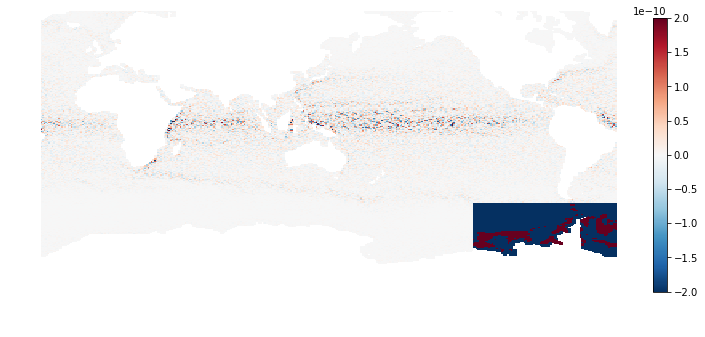

In [58]:
quick_llc_plot((totalH-tendH).sum(dim='k').sum(dim='time')*land_mask, 
               add_colorbar=False, axis_off=True, cmap='RdBu_r',vmin=-2e-10,vmax=2e-10)

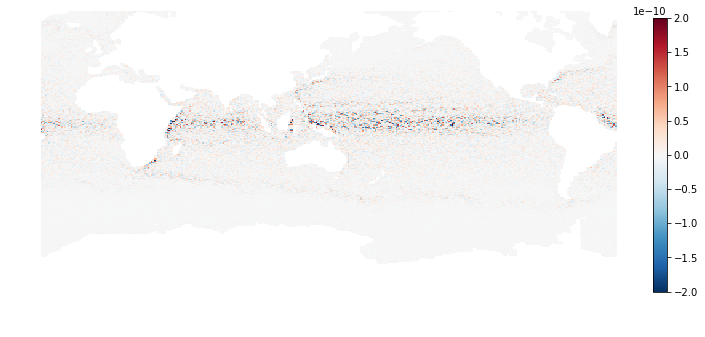

### Time series for an arbitrarily chosen grid point

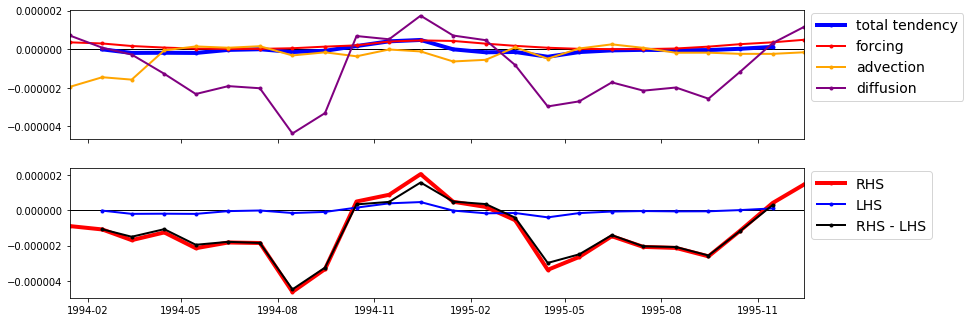

In [59]:
f = 12
k = 1
j = 10
i = 10

fig, axes = plt.subplots(2, 1,figsize=(12,5))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(tendH.time, tendH[:,f,k,j,i], lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcH.time, forcH[:,f,k,j,i], lw=2, color='red', marker='.',label='forcing')
plt.plot(adv_ConvH.time, adv_ConvH[:,f,k,j,i], lw=2, color='orange', marker='.',label='advection')
plt.plot(dif_ConvH.time, dif_ConvH[:,f,k,j,i], lw=2, color='purple', marker='.',label='diffusion')
plt.xlim([ds_ave.time.values[0],ds_ave.time.values[-1]])
plt.setp(plt.gca(), 'xticklabels',[])
plt.legend(fontsize=14,bbox_to_anchor=(1.0, 1.03))

plt.subplot(2, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(totalH.time, totalH[:,f,k,j,i], lw=4, color='red', marker='.',label='RHS')
plt.plot(tendH.time, tendH[:,f,k,j,i], lw=2, color='blue', marker='.',label='LHS')
plt.plot(tendH.time, totalH[:,f,k,j,i]-tendH[:,f,k,j,i], lw=2, color='k', marker='.',label='RHS - LHS')
plt.xlim([ds_ave.time.values[0],ds_ave.time.values[-1]])
plt.legend(fontsize=14,bbox_to_anchor=(1.0, 1.03))

fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.9)
plt.show()

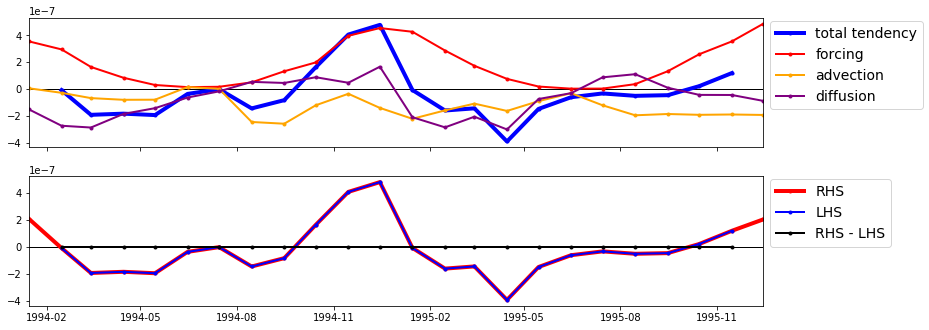

### Verical profiles for an arbitrarily chosen grid point

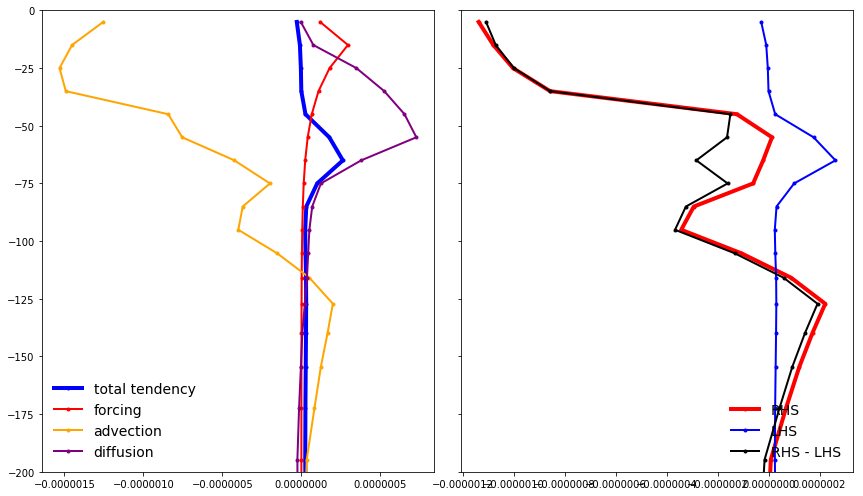

In [60]:
t = 1
f = 12
j = 10
i = 10

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12,7))
fig.tight_layout()

plt.subplot(1, 2, 1)
plt.plot(tendH[t,f,:,j,i],tendH.Z, lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcH[t,f,:,j,i],forcH.Z, lw=2, color='red', marker='.',label='forcing')
plt.plot(adv_ConvH[t,f,:,j,i],adv_ConvH.Z, lw=2, color='orange', marker='.',label='advection')
plt.plot(dif_ConvH[t,f,:,j,i],dif_ConvH.Z, lw=2, color='purple', marker='.',label='diffusion')
plt.legend(loc='lower left',frameon=False,fontsize=14)
plt.ylim([-200,0])

plt.subplot(1, 2, 2)
plt.plot(totalH[t,f,:,j,i],totalH.Z, lw=4, color='red', marker='.',label='RHS')
plt.plot(tendH[t,f,:,j,i],tendH.Z, lw=2, color='blue', marker='.',label='LHS')
plt.plot(totalH[t,f,:,j,i]-tendH[t,f,:,j,i],tendH.Z, lw=2, color='k', marker='.',label='RHS - LHS')
plt.setp(plt.gca(), 'yticklabels',[])
plt.legend(loc='lower right',frameon=False,fontsize=14)
plt.ylim([-200,0])

plt.show()

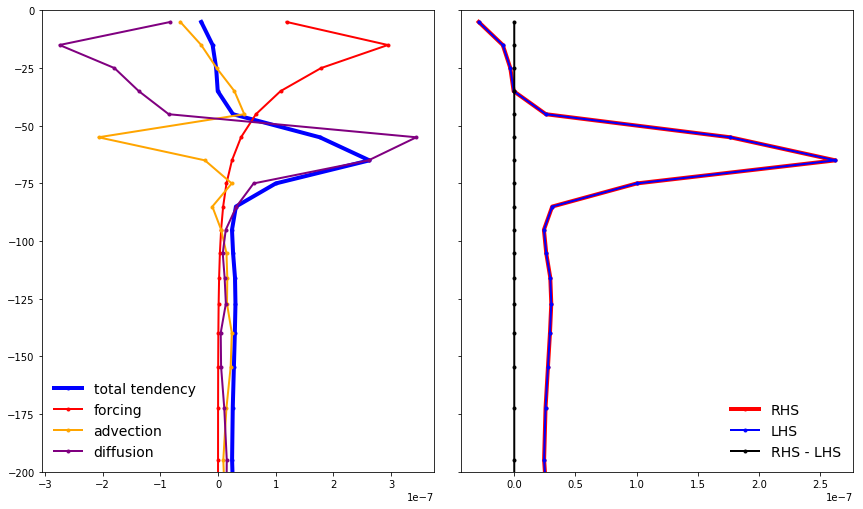